# **Interpréter les modèles Transformers**

Dans ce tutoriel proposé par [Captum](https://captum.ai/tutorials/Bert_SQUAD_Interpret).
Nous allons explorer comment interpréter BERT en utilisant l’ensemble de données SQuAD (Stanford Question Answering Dataset). BERT (Bidirectional Encoder Representations from Transformers) est un modèle de traitement du langage naturel (NLP) basé sur l’architecture des transformateurs, développé par Google. Il a révolutionné le domaine en introduisant une approche bidirectionnelle de l’apprentissage des représentations textuelles, permettant une meilleure compréhension du contexte des mots dans une phrase.

SQuAD est un ensemble de données de questions-réponses contenant des paires de questions et de passages de texte, où chaque réponse est extraite du passage correspondant. Il est souvent utilisé pour évaluer la capacité des modèles de NLP à comprendre et à extraire des informations précises à partir d’un texte donné.

En interprétant BERT sur SQuAD, nous chercherons à comprendre comment le modèle décode les relations sémantiques, comment il attribue des scores de probabilité aux réponses possibles et quelles parties du texte influencent le plus ses prédictions. Cette analyse peut être réalisée grâce à des techniques comme la visualisation des scores d’attention ou l’explication des décisions du modèle à l’aide de méthodes comme Layer-wise Relevance Propagation (LRP).


On installe ici tous les packages nécessaires

In [ ]:
# Packages python requis
!pip install seaborn
!pip install pandas
!pip install matplotlib
!pip install transformers
!pip install captum

#mecab
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.3

#neologd
# !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
# !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

!pip install transformers
!pip install fugashi==1.1.0 ipadic==1.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
# import required python libraries
import numpy as np # multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import pandas as pd # data manipulation and analysis
import seaborn as sns # statistical data visualization
import matplotlib.pyplot as plt # object-oriented API for embedding plots

import torch # data structures for multi-dimensional tensors and defines mathematical operations over these tensors
import torch.nn as nn # basic building blocks for graphs
import json

# from transformers import pipeline
from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig # library for transformer models
from captum.attr import visualization as viz # captum visualization tool for matplotlib figure, it visualizes attribution for a given image by normalizing attribution values of the desired sign
from captum.attr import LayerConductance, LayerIntegratedGradients # computes conductance with respect to the given layer and provides integrated gradients augmenting accuracy metrics, model debugging and feature or rule extraction.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Les parties commentées suggèrent comment utiliser un autre modèle pré-entraîné issu de Hugging Face. Ce modèle est une version de BERT-large-uncased, pré-entraînée sur un corpus de messages Twitter portant sur la COVID-19.

Dans un premier temps, nous effectuons un fine-tuning du modèle BERT sur l’ensemble de données SQuAD. Ici, l’affinage est réalisé à partir d’un modèle pré-entraîné bert-base-uncased.

Une fois le modèle pré-entraîné, nous pouvons charger le tokenizer et le modèle BERT pré-entraîné en utilisant respectivement les commandes BertForQuestionAnswering et BertTokenizer.


Version de Bert en français pour y tester un texte français

In [ ]:
# replace <bert-case-uncased> with the path of the saved model
# https://huggingface.co/bert-base-uncased
model_path = 'dbmdz/bert-base-french-europeana-cased'

#model_path = 'digitalepidemiologylab/covid-twitter-bert-v2'

# pipe = pipeline(task='fill-mask', model='digitalepidemiologylab/covid-twitter-bert-v2')
# out = pipe(f"In places with a lot of people, it's a good idea to wear a {pipe.tokenizer.mask_token}")
# print(json.dumps(out, indent=4))
# [
#     {
#         "sequence": "[CLS] in places with a lot of people, it's a good idea to wear a mask [SEP]",
#         "score": 0.9998226761817932,
#         "token": 7308,
#         "token_str": "mask"
#     },
#     ...
# ]


# load model
model = BertForQuestionAnswering.from_pretrained(model_path)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dbmdz/bert-base-french-europeana-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/227k [00:00<?, ?B/s]

Cette fonction predict prend des entrées (inputs) et des arguments optionnels (token_type_ids, position_ids, attention_mask), puis les passe à un modèle BERT pré-entraîné pour effectuer une prédiction.

In [ ]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits

La fonction squad_pos_forward_func utilise predict pour obtenir les logits de début ou de fin de réponse, selon le paramètre position. Elle sélectionne ensuite le score maximal parmi les logits, indiquant la position la plus probable de la réponse dans le texte.

In [ ]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

Ces lignes récupèrent les identifiants des tokens spéciaux utilisés par le tokenizer de BERT

In [ ]:
ref_token_id = tokenizer.pad_token_id # Identifiant du token de padding (utilisé pour remplir les séquences).
sep_token_id = tokenizer.sep_token_id # Identifiant du token séparateur (utilisé pour séparer la question et le texte, et ajouté à la fin).
cls_token_id = tokenizer.cls_token_id # Identifiant du token [CLS] (ajouté au début de la séquence question-texte pour marquer le début).

In [ ]:
#Crée deux séquences de tokens :
#- input_ids : La séquence combinée question + texte avec tokens spéciaux (CLS, SEP).
#- ref_input_ids : La séquence de référence où chaque token de la question et du texte est remplacé par un token de référence.

def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
        [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)


#Génère les token_type_ids (pour distinguer la question du texte) et la séquence de référence ref_token_type_ids.

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids


#Crée les position_ids (indices des positions des tokens) et la séquence de référence ref_position_ids.
def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


#Crée un masque d'attention (1 pour chaque token) afin d'indiquer quels tokens doivent être pris en compte par le modèle.
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


#Calcule les embeddings d’entrée et de référence en utilisant les tokens d'entrée, les tokens de référence, les token_type_ids, position_ids, et autres.
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids, position_ids=position_ids)

    return input_embeddings, ref_input_embeddings

Nous définissons maintenant une paire question - contexte (ou texte) comme entrée pour notre modèle BERT. L’objectif est d’interpréter sur quelles parties du texte le modèle se focalise lorsqu’il prédit une réponse à la question à partir du contexte donné.

On a changé le texte par un texte en français car on utilise une versionde  Bert en français

In [ ]:
question, text = "Quel est la capitale de la France?", "Paris, située sur les rives de la Seine, est la capitale et la plus grande ville de France."

Nous intégrons ensuite la question et le texte d’entrée, puis nous générons des références ou valeurs de base correspondantes. Pour cela, nous utilisons :


*   La fonction construct_whole_bert_embeddings définie précédemment pour l’encodage des mots,
*   La fonction construct_input_ref_pos_id_pair pour l’encodage des positions,
*   La fonction construct_input_ref_token_type_pair pour l’encodage des types de tokens.

In [ ]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

Nous définissons la vérité terrain (ground truth) pour les positions de début et de fin de la prédiction.

In [ ]:
ground_truth = 'Paris est la capitale et la plus grande ville de France.'

ground_truth_tokens = tokenizer.encode(ground_truth, add_special_tokens=False)
ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1

Pour obtenir notre prédiction, nous utilisons l’entrée, le type de token, l’identifiant de position ainsi qu’un masque d’attention par défaut précédemment calculé.

In [ ]:
start_scores, end_scores = predict(input_ids, \
                                   token_type_ids=token_type_ids, \
                                   position_ids=position_ids, \
                                   attention_mask=attention_mask)


print('Question: ', question)
print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))

Question:  Quel est la capitale de la France?
Predicted Answer:  ? [SEP] Paris ,


Il existe deux méthodes pour calculer les attributions des couches d’embedding.

1.   La première consiste à utiliser LayerIntegratedGradients et à calculer les attributions par rapport à BertEmbedding dans son ensemble.
2.   La seconde option utilise LayerIntegratedGradients séparément pour each word_embeddings, token_type_embeddings et position_embeddings, en calculant les attributions par rapport à chaque vecteur d’embedding individuellement.




In [ ]:
lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                  baselines=ref_input_ids,
                                  additional_forward_args=(token_type_ids, position_ids, attention_mask, 0),
                                  return_convergence_delta=True)
attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                additional_forward_args=(token_type_ids, position_ids, attention_mask, 1),
                                return_convergence_delta=True)


Nous créons ensuite une fonction utilitaire pour résumer les attributions : summarize_attributions, qui permet d’agréger les attributions pour chaque token de mot dans la séquence.

In [ ]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [ ]:
#Résume les attributions pour la position de début et de fin de la réponse
attributions_start_sum = summarize_attributions(attributions_start)
attributions_end_sum = summarize_attributions(attributions_end)

Ce code crée des objets de type VisualizationDataRecord pour stocker des informations nécessaires à la visualisation des attributions des positions de début et de fin de la réponse :

1. start_position_vis : Contient des informations sur l'attribution pour la position de début, y compris les scores prédits (start_scores), la vérité terrain, la somme des attributions et les tokens associés.

2. end_position_vis : Semblable à start_position_vis, mais pour la position de fin.

Ensuite, il utilise viz.visualize_text pour afficher les visualisations pour les positions de début et de fin, ce qui permet d'analyser l'importance des tokens dans la prédiction de la réponse.

In [ ]:
# storing couple samples in an array for visualization purposes
start_position_vis = viz.VisualizationDataRecord(
                        attributions_start_sum,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        torch.argmax(start_scores),
                        str(ground_truth_start_ind),
                        attributions_start_sum.sum(),
                        all_tokens,
                        delta_start)

end_position_vis = viz.VisualizationDataRecord(
                        attributions_end_sum,
                        torch.max(torch.softmax(end_scores[0], dim=0)),
                        torch.argmax(end_scores),
                        torch.argmax(end_scores),
                        str(ground_truth_end_ind),
                        attributions_end_sum.sum(),
                        all_tokens,
                        delta_end)

print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([start_position_vis])

print('\033[1m', 'Visualizations For End Position', '\033[0m')
viz.visualize_text([end_position_vis])

 Visualizations For Start Position 


 Visualizations For End Position 


Le code utilise LayerIntegratedGradients pour calculer l'importance des embeddings (mots, types de tokens, positions) dans BERT pour les positions de début et de fin de la réponse. Ensuite, summarize_attributions résume les attributions pour chaque type d'embedding, afin de visualiser leur influence sur la prédiction.

In [ ]:
lig2 = LayerIntegratedGradients(squad_pos_forward_func, \
                                [model.bert.embeddings.word_embeddings, \
                                 model.bert.embeddings.token_type_embeddings, \
                                 model.bert.embeddings.position_embeddings])

attributions_start = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask, 0))
attributions_end = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask, 1))

attributions_start_word = summarize_attributions(attributions_start[0])
attributions_end_word = summarize_attributions(attributions_end[0])

attributions_start_token_type = summarize_attributions(attributions_start[1])
attributions_end_token_type = summarize_attributions(attributions_end[1])

attributions_start_position = summarize_attributions(attributions_start[2])
attributions_end_position = summarize_attributions(attributions_end[2])

/usr/local/lib/python3.11/dist-packages/captum/attr/_core/layer/layer_integrated_gradients.py:101: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


In [ ]:
#Sélectionne les k tokens les plus attribués en fonction de leurs scores d'attribution
def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

1. On utilise la fontion qu'on vient de définir

2. Les attributions sont formatées sous forme de chaînes et stockées dans deux DataFrames : un pour la position de début (df_start) et un pour la position de fin (df_end).
Chaque DataFrame contient trois colonnes pour chaque type d'attribution : mots, types de tokens, et positions, accompagnés de leurs indices et valeurs d'attribution.

3. Les styles sont appliqués pour afficher les DataFrames de manière esthétique (sans les ID des cellules).

4. La dernière ligne génère une liste des tokens avec leurs indices, formatée sous forme de chaînes comme token(index).

In [ ]:
top_words_start, top_words_val_start, top_word_ind_start = get_topk_attributed_tokens(attributions_start_word)
top_words_end, top_words_val_end, top_words_ind_end = get_topk_attributed_tokens(attributions_end_word)

top_token_type_start, top_token_type_val_start, top_token_type_ind_start = get_topk_attributed_tokens(attributions_start_token_type)
top_token_type_end, top_token_type_val_end, top_token_type_ind_end = get_topk_attributed_tokens(attributions_end_token_type)

top_pos_start, top_pos_val_start, pos_ind_start = get_topk_attributed_tokens(attributions_start_position)
top_pos_end, top_pos_val_end, pos_ind_end = get_topk_attributed_tokens(attributions_end_position)

df_start = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_start, top_word_ind_start, top_words_val_start)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_start, top_token_type_ind_start, top_words_val_start)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_start, pos_ind_start, top_pos_val_start)]})
df_start.style.apply(['cell_ids: False'])

df_end = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_end, top_words_ind_end, top_words_val_end)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_end, top_token_type_ind_end, top_words_val_end)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_end, pos_ind_end, top_pos_val_end)]})
df_end.style.apply(['cell_ids: False'])

['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

['[CLS](0)',
 'Quel(1)',
 'est(2)',
 'la(3)',
 'capitale(4)',
 'de(5)',
 'la(6)',
 'France(7)',
 '?(8)',
 '[SEP](9)',
 'Paris(10)',
 ',(11)',
 'située(12)',
 'sur(13)',
 'les(14)',
 'rives(15)',
 'de(16)',
 'la(17)',
 'Seine(18)',
 ',(19)',
 'est(20)',
 'la(21)',
 'capitale(22)',
 'et(23)',
 'la(24)',
 'plus(25)',
 'grande(26)',
 'ville(27)',
 'de(28)',
 'France(29)',
 '.(30)',
 '[SEP](31)']

On affiche les résultats contenus dans les DataFrame

In [ ]:
df_start

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,"et (23), 0.56","[SEP] (31), 0.56","[SEP] (31), 0.57"
1,"capitale (4), 0.36",". (30), 0.36","et (23), 0.29"
2,"située (12), 0.35",", (19), 0.35",". (30), 0.29"
3,"capitale (22), 0.28","et (23), 0.28","Seine (18), 0.25"
4,"France (7), 0.23",", (11), 0.23","rives (15), 0.24"


Pour le début de la réponse, les tokens comme "[SEP]", "et" et "." sont considérés comme essentiels pour déterminer le début de la réponse.

In [ ]:
df_end

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,"est (20), 0.44","ville (27), 0.44","est (20), 0.29"
1,"est (2), 0.36",", (11), 0.36","[SEP] (9), 0.26"
2,"rives (15), 0.34","située (12), 0.34","[SEP] (31), 0.21"
3,"la (24), 0.31","les (14), 0.31","de (28), 0.18"
4,"France (29), 0.31","[SEP] (31), 0.31","France (29), 0.13"


Les mots clés comme "ville", "est", et "située" apparaissent dans les positions de fin, ce qui montre que ces éléments contextuels aident le modèle à déterminer où la réponse se termine.

In [ ]:
#Prend les embeddings d'entrée et un masque d'attention pour faire une prédiction sur la position de début ou de fin de la réponse dans le modèle BERT fine-tuné pour SQuAD. Elle retourne la valeur maximale de la prédiction pour la position donnée.
def squad_pos_forward_func2(input_emb, attention_mask=None, position=0):
    pred = model(inputs_embeds=input_emb, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values

Calcule les attributions des couches du modèle BERT pour les positions de début et de fin dans SQuAD. Il extrait les attributions pour chaque couche et résume les résultats. Il se concentre également sur un token spécifique (token_to_explain) pour examiner ses attributions à travers les différentes couches.

In [ ]:
layer_attrs_start = []
layer_attrs_end = []

# The token that we would like to examine separately.
token_to_explain = 14 # the index of the token that we would like to examine more thoroughly
layer_attrs_start_dist = []
layer_attrs_end_dist = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func2, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 0))
    layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 1))
    layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
    layer_attrs_end.append(summarize_attributions(layer_attributions_end).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_start_dist.append(layer_attributions_start[0,token_to_explain,:].cpu().detach().tolist())
    layer_attrs_end_dist.append(layer_attributions_end[0,token_to_explain,:].cpu().detach().tolist())

Ce graphique (heatmap) visualise l'importance des tokens pour chaque couche du modèle BERT, montrant comment chaque couche contribue à la prédiction de la position de début dans la tâche SQuAD.

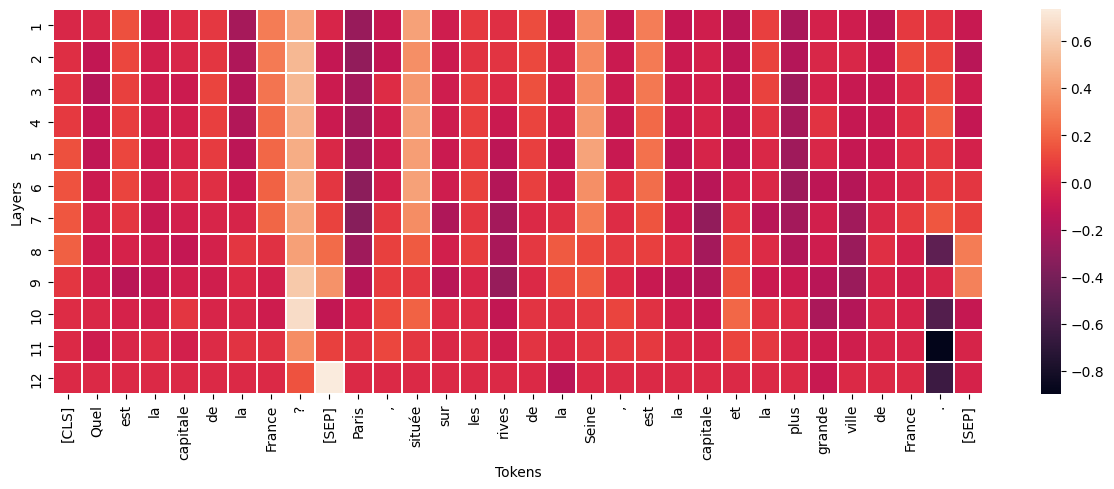

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_start), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

Pareil que le graphique précédent mais pour la position de fin

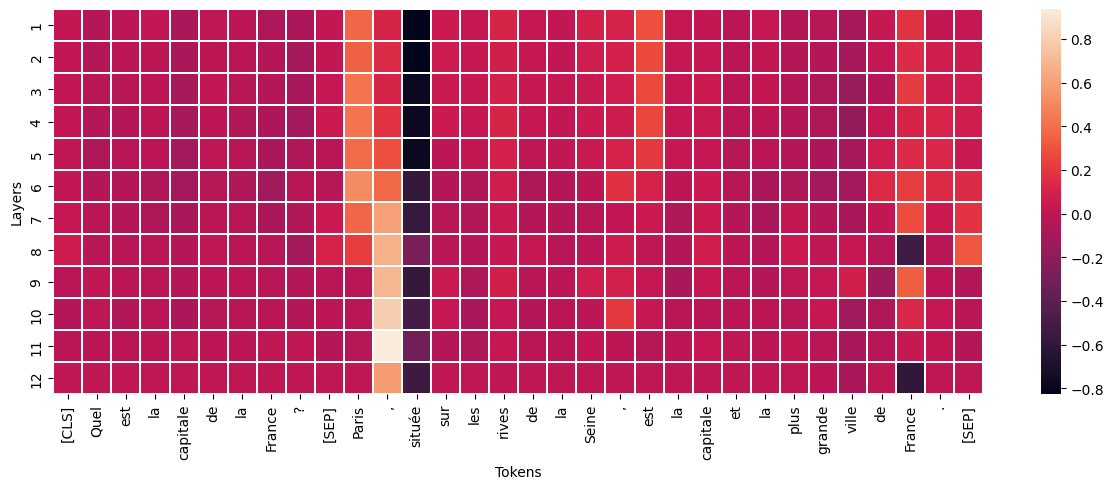

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_end), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

Diagramme en boîte (boxplot) pour visualiser la distribution des attributions pour la position de départ (start position) à travers différentes couches du modèle BERT.

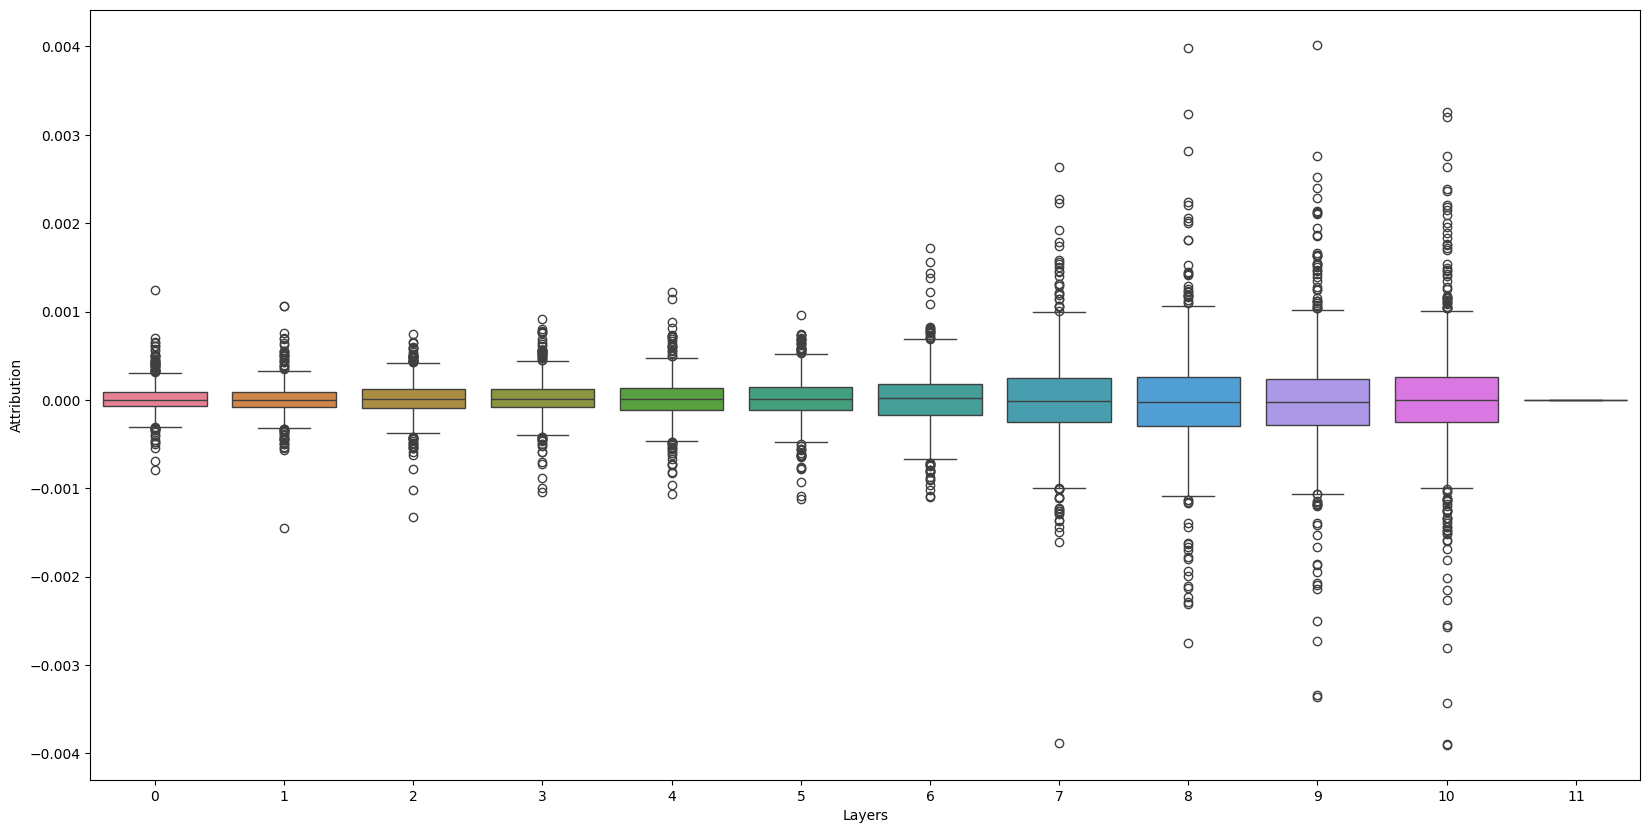

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_start_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

Pareil pour la position de fin

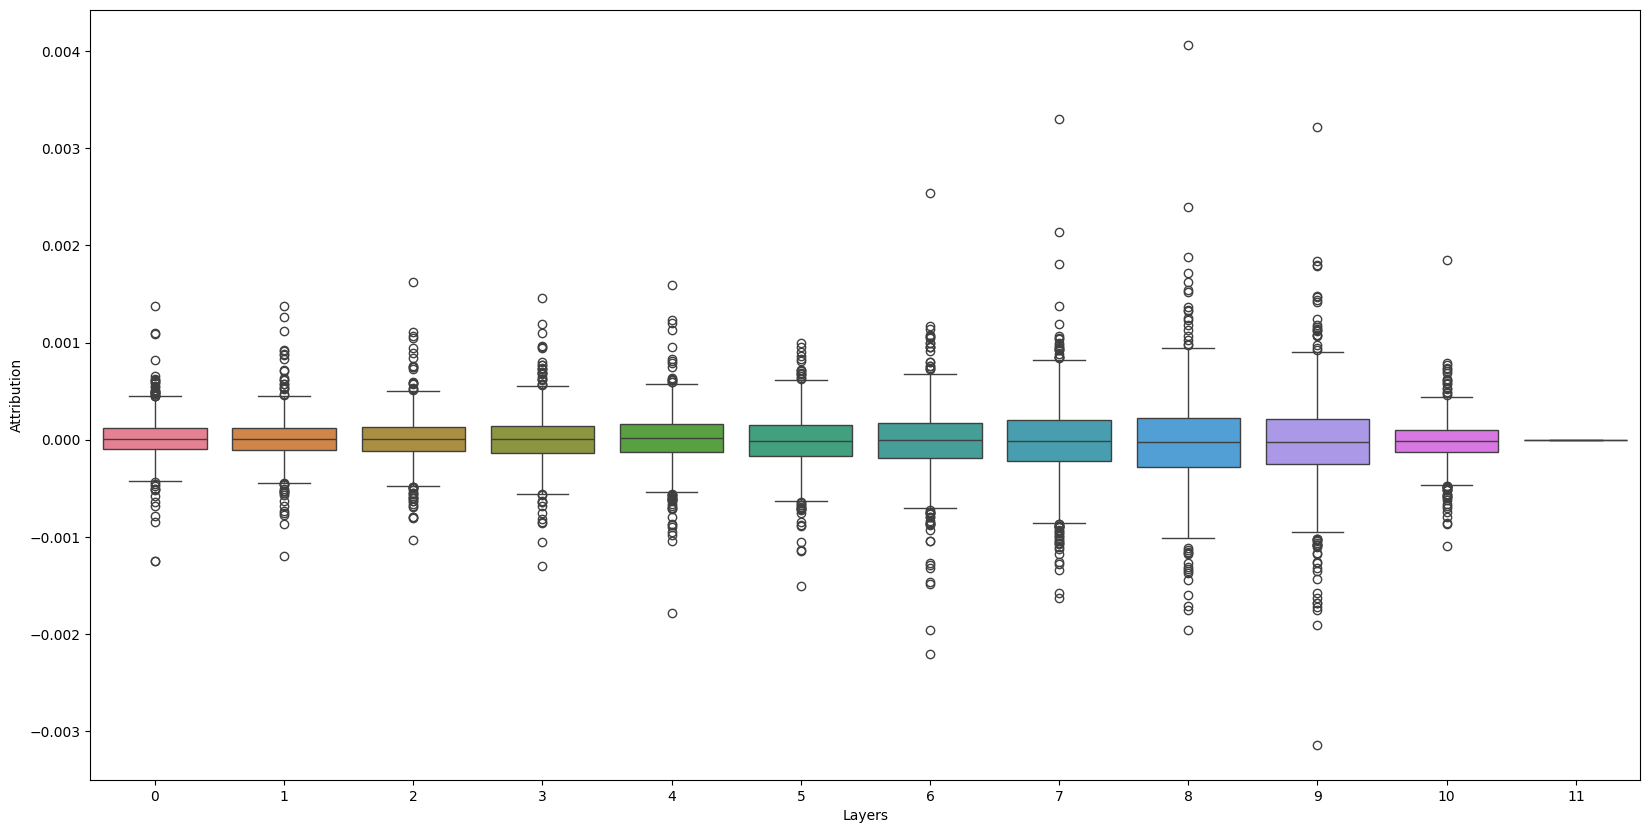

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_end_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

In [ ]:
def pdf_attr(attrs, bins=100):
    # Utilisation de numpy pour calculer l'histogramme normalisé des attributions
    return np.histogram(attrs, bins=bins, density=True)[0]

Calcule et normalise les attributions des couches de BERT pour les positions de début et de fin d'une réponse.

1. Les attributions sont transformées en histogrammes pour chaque couche.
2. Les attributions sont sommées pour chaque couche.
3. Les attributions sont normalisées par la norme L1 pour chaque couche.
4. Les résultats sont transposés et normalisés pour rendre les couches comparables.

In [ ]:
layer_attrs_end_pdf = map(lambda layer_attrs_end_dist: pdf_attr(layer_attrs_end_dist), layer_attrs_end_dist)
layer_attrs_end_pdf = np.array(list(layer_attrs_end_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_end_dist).sum(-1)

# size: #layers
layer_attrs_end_pdf_norm = np.linalg.norm(layer_attrs_end_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_end_pdf = np.transpose(layer_attrs_end_pdf)

#size: #bins x #layers
layer_attrs_end_pdf = np.divide(layer_attrs_end_pdf, layer_attrs_end_pdf_norm, where=layer_attrs_end_pdf_norm!=0)

Visualisation de la distribution des attributions au sein des différentes couches du modèle BERT

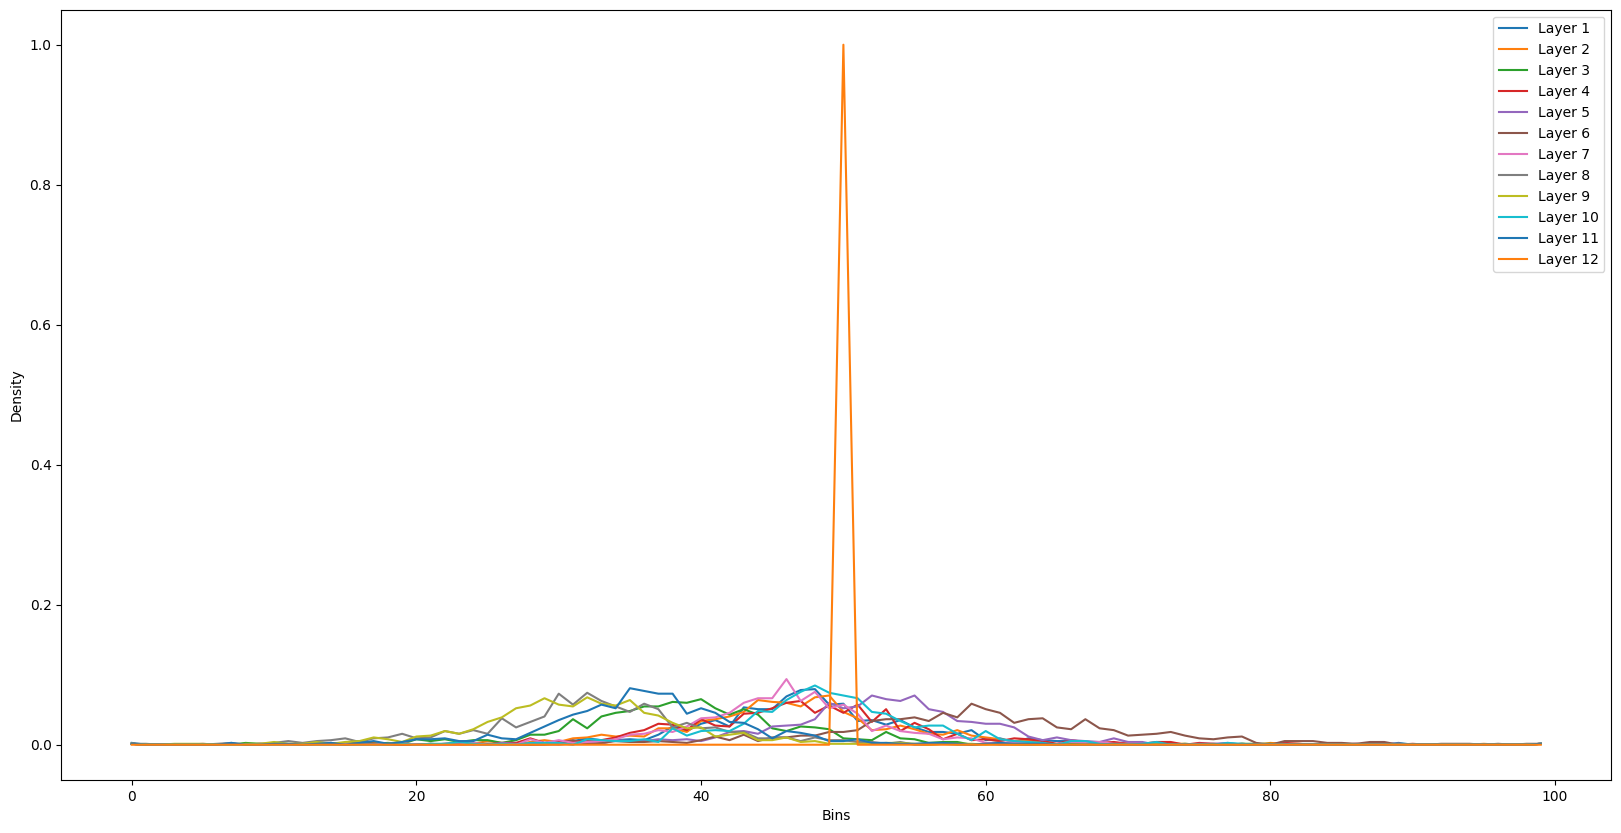

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_end_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,13)])
plt.show()

Montre comment la distribution des attributions dans les couches est liée à leur entropie

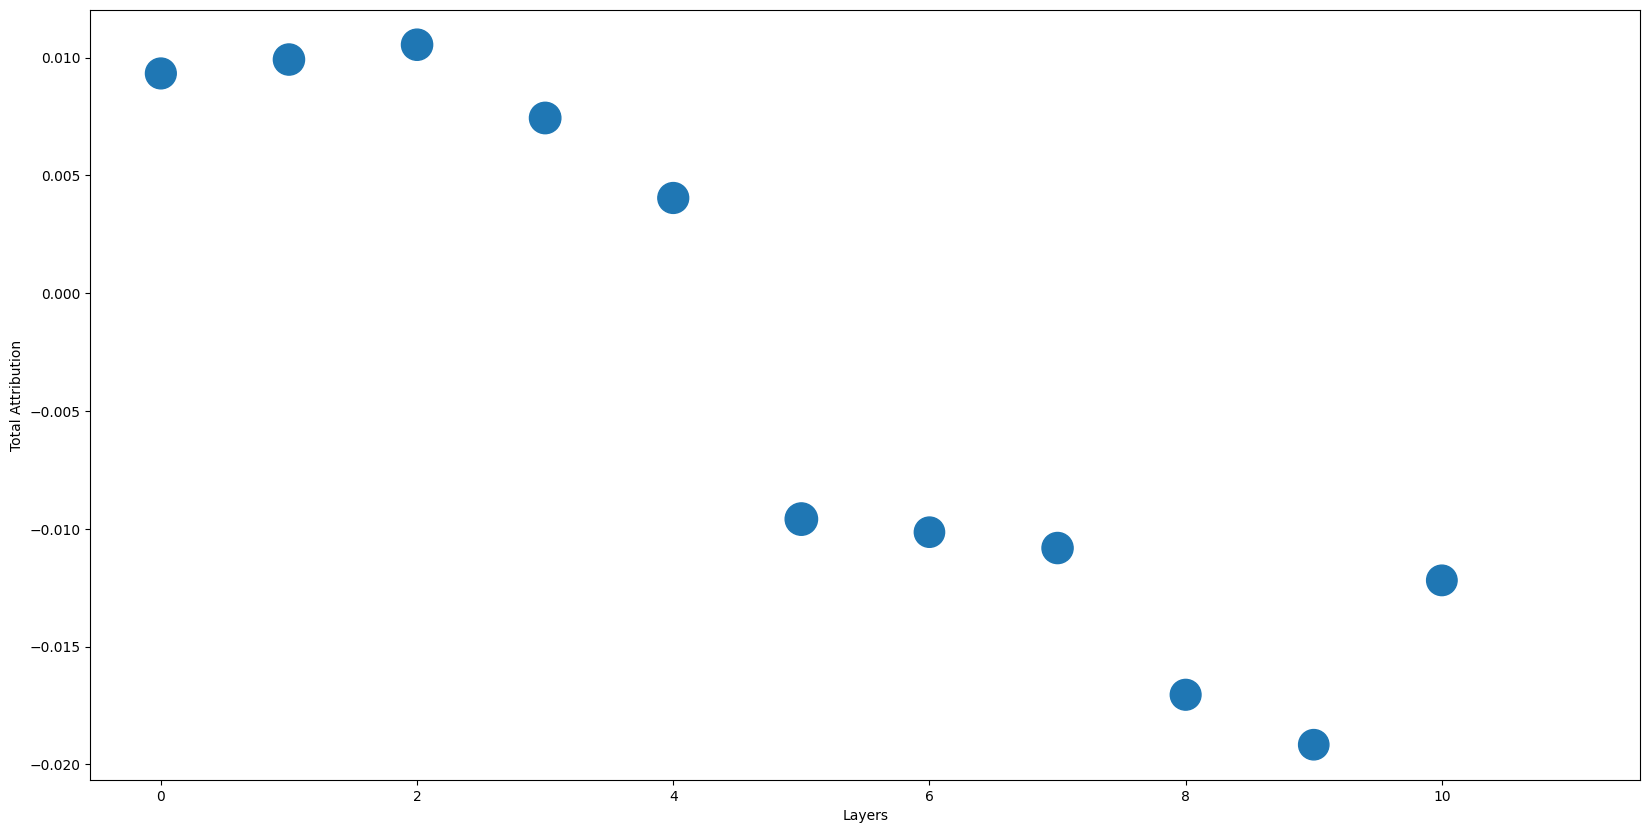

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_end_pdf[layer_attrs_end_pdf == 0] = 1
layer_attrs_end_pdf_log = np.log2(layer_attrs_end_pdf)

# size: #layers
entropies= -(layer_attrs_end_pdf * layer_attrs_end_pdf_log).sum(0)

plt.scatter(np.arange(12), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()